<a href="https://colab.research.google.com/github/AleOi2/PSI3472/blob/master/Aula7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercício 1 - Maior 1

In [ ]:
#fcn-train1.py - grad2020 - testada em colab para TF2
#Treina rede fcn para segmentacao semantica de eliret
import cv2
import numpy as np
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dropout, Conv2D, Conv2DTranspose
from keras import optimizers
import sys
import PIL
from PIL import Image
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
from google.colab import drive
drive.mount('/content/drive')

def leCsv(nomeDir,nomeArq):
  n=0
  arq=open(os.path.join(nomeDir,nomeArq),"r")
  for linha in arq:
    n=n+1

  nl,nc = 72,88
  AX=np.empty((n,nl,nc),dtype='uint8')
  AY=np.empty((n,nl,nc),dtype='uint8')

  i=0; arq.seek(0)
  print("Lendo: ",nomeArq)
  for linha in arq:
    linha=linha.strip('\n')
    linha=linha.split(';')
    img = Image.open(os.path.join(nomeDir,linha[0]))
    img = img.resize((nc, nl), PIL.Image.ANTIALIAS)
    AX[i]=img
    img = Image.open(os.path.join(nomeDir,linha[1]))
    img = img.resize((nc, nl), PIL.Image.ANTIALIAS)    
    AY[i]=img
    i=i+1
  arq.close()

  ax= np.float32(AX)/255.0 #Entre 0 e +1
  ay= np.float32(AY)/255.0 #Entre 0 e +1
  ax = ax.reshape(n, nl, nc, 1)
  ay = ay.reshape(n, nl, nc, 1)
  return ax, ay

#main
bdDir = "/content/drive/My Drive/Colab Notebooks/psi3472/Aula7/haebase/segm_eliret"
ax, ay = leCsv(bdDir,"treino.csv")
vx, vy = leCsv(bdDir,"valida.csv")
qx, qy = leCsv(bdDir,"teste.csv")
outDir = "/content/drive/My Drive/Colab Notebooks/psi3472/Aula7/haebase/segm_eliret_out"; os.chdir(outDir) 

nl,nc = 72,88; input_shape = (nl,nc,1)
batch_size = 20
epochs = 1000

model = Sequential()
model.add(Conv2D(40, kernel_size=(5,5), strides=2, activation='relu',
                 padding='same', input_shape=input_shape)) #saida 16*16
model.add(Dropout(0.25))
model.add(Conv2D(12, kernel_size=(5,5), strides=2, activation='relu',
                 padding='same')) #saida 8*8
model.add(Dropout(0.25))
model.add(Conv2D(12, kernel_size=(5,5), strides=2, activation='relu',
                 padding='same')) #saida 4*4
model.add(Dropout(0.25))
model.add(Conv2DTranspose(12, kernel_size=(5,5), strides=2, activation='relu',
                 padding='same')) #saida 8*8
model.add(Dropout(0.25))
model.add(Conv2DTranspose(40, kernel_size=(5,5), strides=2, activation='relu',
                 padding='same')) #saida 16*16
model.add(Dropout(0.25))
model.add(Conv2DTranspose(1, kernel_size=(5,5), strides=2, padding='same')) #saida 32*32

from keras.utils import plot_model
plot_model(model, to_file='fcn-train1.png', show_shapes=True)
model.summary()


opt=optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')

model.fit(ax, ay, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(vx,vy))

score = model.evaluate(ax, ay, verbose=0)
print('Training loss:', score)
score = model.evaluate(vx, vy, verbose=0)
print('Validation loss:', score)
score = model.evaluate(qx, qy, verbose=0)
print('Test loss:', score)

model.save('fcn1.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Lendo:  treino.csv
Lendo:  valida.csv
Lendo:  teste.csv
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 44, 40)        1040      
_________________________________________________________________
dropout (Dropout)            (None, 36, 44, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 22, 12)        12012     
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 22, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 11, 12)         3612      
_________________________________________________________________
dro

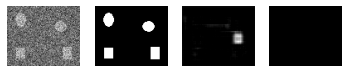

In [ ]:
#fcn-pred1.py - grad2020 - testada em colab para TF2
#Faz segmentacao semantica usando rede gerada pelo fcn-train1.py
import cv2
import numpy as np
import keras
from keras.models import load_model
from keras.layers import Dropout, Conv2D, Conv2DTranspose
from keras import optimizers
import sys
from sys import argv
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

#<<<<<<<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<<<<<<
bdDir = "/content/drive/My Drive/Colab Notebooks/psi3472/Aula7/haebase/segm_eliret"
outDir = "/content/drive/My Drive/Colab Notebooks/psi3472/Aula7/haebase/segm_eliret_out"; os.chdir(outDir) 
nome="maior1"
inImgX = nome+"x.png"
inImgY = nome+"y.png"
outImgG =nome+"g.png"
outImgB =nome+"b.png"
arquivoRede = "fcn1.h5"

model = load_model(os.path.join(outDir,arquivoRede))
QX=cv2.imread(os.path.join(bdDir,inImgX),0)
QY=cv2.imread(os.path.join(bdDir,inImgY),0)
nl=QX.shape[0]; nc=QX.shape[1]
qx=np.float32(QX)/255.0 #Entre 0 e +1
qx=qx.reshape(1, nl, nc, 1)

qp=model.predict(qx)
qp=qp.reshape(nl,nc) # entre 0 e +1

QPG=255.0*qp 
QPG=np.clip(QPG,0,255) # Entre 0 e 255
QPG=np.uint8(QPG)
cv2.imwrite(os.path.join(outDir,outImgG),QPG)

QPB=np.zeros((nl,nc),dtype='uint8')
QPB[ qp>=0.5 ] = 255
cv2.imwrite(os.path.join(outDir,outImgB),QPB)

from matplotlib import pyplot as plt
f = plt.figure()
f.add_subplot(1,4,1)
plt.imshow(QX,cmap="gray")
plt.axis('off')
f.add_subplot(1,4,2)
plt.imshow(QY,cmap="gray")
plt.axis('off')
f.add_subplot(1,4,3)
plt.imshow(QPG,cmap="gray")
plt.axis('off')
f.add_subplot(1,4,4)
plt.imshow(QPB,cmap="gray")
plt.axis('off')
plt.show(block=True)

# Exercício 1 - Maior 2

In [ ]:
#fcn-train1.py - grad2020 - testada em colab para TF2
#Treina rede fcn para segmentacao semantica de eliret
import cv2
import numpy as np
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dropout, Conv2D, Conv2DTranspose
from keras import optimizers
import sys
import PIL
from PIL import Image
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
from google.colab import drive
drive.mount('/content/drive')

def leCsv(nomeDir,nomeArq):
  n=0
  arq=open(os.path.join(nomeDir,nomeArq),"r")
  for linha in arq:
    n=n+1

  nl,nc = 80,88
  AX=np.empty((n,nl,nc),dtype='uint8')
  AY=np.empty((n,nl,nc),dtype='uint8')

  i=0; arq.seek(0)
  print("Lendo: ",nomeArq)
  for linha in arq:
    linha=linha.strip('\n')
    linha=linha.split(';')
    img = Image.open(os.path.join(nomeDir,linha[0]))
    img = img.resize((nc, nl), PIL.Image.ANTIALIAS)
    AX[i]=img
    img = Image.open(os.path.join(nomeDir,linha[1]))
    img = img.resize((nc, nl), PIL.Image.ANTIALIAS)    
    AY[i]=img
    i=i+1
  arq.close()

  ax= np.float32(AX)/255.0 #Entre 0 e +1
  ay= np.float32(AY)/255.0 #Entre 0 e +1
  ax = ax.reshape(n, nl, nc, 1)
  ay = ay.reshape(n, nl, nc, 1)
  return ax, ay

#main
bdDir = "/content/drive/My Drive/Colab Notebooks/psi3472/Aula7/haebase/segm_eliret"
ax, ay = leCsv(bdDir,"treino.csv")
vx, vy = leCsv(bdDir,"valida.csv")
qx, qy = leCsv(bdDir,"teste.csv")
outDir = "/content/drive/My Drive/Colab Notebooks/psi3472/Aula7/haebase/segm_eliret_out"; os.chdir(outDir) 

nl,nc = 80,88; input_shape = (nl,nc,1)
batch_size = 20
epochs = 1000

model = Sequential()
model.add(Conv2D(40, kernel_size=(5,5), strides=2, activation='relu',
                 padding='same', input_shape=input_shape)) #saida 16*16
model.add(Dropout(0.25))
model.add(Conv2D(12, kernel_size=(5,5), strides=2, activation='relu',
                 padding='same')) #saida 8*8
model.add(Dropout(0.25))
model.add(Conv2D(12, kernel_size=(5,5), strides=2, activation='relu',
                 padding='same')) #saida 4*4
model.add(Dropout(0.25))
model.add(Conv2DTranspose(12, kernel_size=(5,5), strides=2, activation='relu',
                 padding='same')) #saida 8*8
model.add(Dropout(0.25))
model.add(Conv2DTranspose(40, kernel_size=(5,5), strides=2, activation='relu',
                 padding='same')) #saida 16*16
model.add(Dropout(0.25))
model.add(Conv2DTranspose(1, kernel_size=(5,5), strides=2, padding='same')) #saida 32*32

from keras.utils import plot_model
plot_model(model, to_file='fcn-train1.png', show_shapes=True)
model.summary()


opt=optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')

model.fit(ax, ay, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(vx,vy))

score = model.evaluate(ax, ay, verbose=0)
print('Training loss:', score)
score = model.evaluate(vx, vy, verbose=0)
print('Validation loss:', score)
score = model.evaluate(qx, qy, verbose=0)
print('Test loss:', score)

model.save('fcn2.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Lendo:  treino.csv
Lendo:  valida.csv
Lendo:  teste.csv
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 40, 44, 40)        1040      
_________________________________________________________________
dropout_10 (Dropout)         (None, 40, 44, 40)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 22, 12)        12012     
_________________________________________________________________
dropout_11 (Dropout)         (None, 20, 22, 12)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 11, 12)        3612      
_________________________________________________________________
d

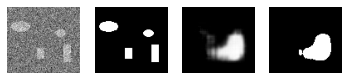

In [ ]:
#fcn-pred1.py - grad2020 - testada em colab para TF2
#Faz segmentacao semantica usando rede gerada pelo fcn-train1.py
import cv2
import numpy as np
import keras
from keras.models import load_model
from keras.layers import Dropout, Conv2D, Conv2DTranspose
from keras import optimizers
import sys
from sys import argv
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

#<<<<<<<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<<<<<<
bdDir = "/content/drive/My Drive/Colab Notebooks/psi3472/Aula7/haebase/segm_eliret"
outDir = "/content/drive/My Drive/Colab Notebooks/psi3472/Aula7/haebase/segm_eliret_out"; os.chdir(outDir) 
nome="maior2"
inImgX = nome+"x.png"
inImgY = nome+"y.png"
outImgG =nome+"g.png"
outImgB =nome+"b.png"
arquivoRede = "fcn2.h5"

model = load_model(os.path.join(outDir,arquivoRede))
QX=cv2.imread(os.path.join(bdDir,inImgX),0)
QY=cv2.imread(os.path.join(bdDir,inImgY),0)
nl=QX.shape[0]; nc=QX.shape[1]
qx=np.float32(QX)/255.0 #Entre 0 e +1
qx=qx.reshape(1, nl, nc, 1)

qp=model.predict(qx)
qp=qp.reshape(nl,nc) # entre 0 e +1

QPG=255.0*qp 
QPG=np.clip(QPG,0,255) # Entre 0 e 255
QPG=np.uint8(QPG)
cv2.imwrite(os.path.join(outDir,outImgG),QPG)

QPB=np.zeros((nl,nc),dtype='uint8')
QPB[ qp>=0.5 ] = 255
cv2.imwrite(os.path.join(outDir,outImgB),QPB)

from matplotlib import pyplot as plt
f = plt.figure()
f.add_subplot(1,4,1)
plt.imshow(QX,cmap="gray")
plt.axis('off')
f.add_subplot(1,4,2)
plt.imshow(QY,cmap="gray")
plt.axis('off')
f.add_subplot(1,4,3)
plt.imshow(QPG,cmap="gray")
plt.axis('off')
f.add_subplot(1,4,4)
plt.imshow(QPB,cmap="gray")
plt.axis('off')
plt.show(block=True)

# Exercício 2

Epoch 1/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2828 - accuracy: 0.1667
Epoch 2/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2761 - accuracy: 0.1667
Epoch 3/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2811 - accuracy: 0.0000e+00
Epoch 4/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2513 - accuracy: 0.1667
Epoch 5/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2550 - accuracy: 0.3333
Epoch 6/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2451 - accuracy: 0.3333
Epoch 7/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2701 - accuracy: 0.0000e+00
Epoch 8/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2591 - accuracy: 0.1667
Epoch 9/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2455 - accuracy: 0.5000
Epoch 10/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2380 - accuracy: 0.3333
Epoch 11/500
3/3 [===

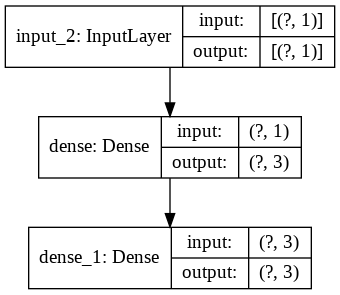

In [ ]:
#abc1.py - pos2021
import cv2
import numpy as np
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dropout, Conv2D, Conv2DTranspose
from keras import optimizers
import sys
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

inputs = keras.Input(shape=(1,))
x = keras.layers.Dense(3, activation='sigmoid')(inputs)
outputs = keras.layers.Dense(3, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)


sgd=optimizers.SGD(lr=10);
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
ax = np.matrix('4; 15; 65; 5; 18; 70 ',dtype="float32")
ax=ax/100
ay = np.matrix('0 1 0; 0 0 1; 1 0 0; 0 1 0; 0 0 1; 1 0 0',dtype="float32")
model.fit(ax, ay, epochs=500, batch_size=2, verbose=True)
qx = np.matrix('16; 3; 75 ',dtype="float32")
qx=qx/100
qy = np.matrix('0 0 1; 0 1 0; 1 0 0',dtype="float32")
teste = model.evaluate(qx,qy)
print("Custo e acuracidade de teste:",teste)
qp=model.predict(qx)
print("Classificacao de teste:\n",qp)
qp = qp.argmax(axis=-1)
print("Rotulo de saida:\n",qp)
from keras.utils import plot_model
plot_model(model, to_file='abc1.png', show_shapes=True)

# Exercício 2

Epoch 1/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2873 - accuracy: 0.0000e+00
Epoch 2/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2846 - accuracy: 0.1667
Epoch 3/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2635 - accuracy: 0.3333
Epoch 4/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2663 - accuracy: 0.3333
Epoch 5/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2681 - accuracy: 0.1667
Epoch 6/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2677 - accuracy: 0.3333
Epoch 7/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2533 - accuracy: 0.3333
Epoch 8/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2347 - accuracy: 0.3333
Epoch 9/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2950 - accuracy: 0.0000e+00
Epoch 10/500
3/3 [==============================] - 0s 2ms/step - loss: 0.2277 - accuracy: 0.3333
Epoch 11/500
3/3 [===

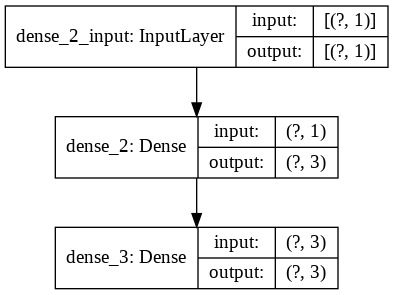

In [ ]:
#abc1.py - pos2021
import tensorflow
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
import numpy as np
import sys
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
model = Sequential();
model.add(Dense(3, activation='sigmoid', input_dim=1))
model.add(Dense(3, activation='sigmoid'))
sgd=optimizers.SGD(lr=10);
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
ax = np.matrix('4; 15; 65; 5; 18; 70 ',dtype="float32")
ax=ax/100
ay = np.matrix('0 1 0; 0 0 1; 1 0 0; 0 1 0; 0 0 1; 1 0 0',dtype="float32")
model.fit(ax, ay, epochs=500, batch_size=2, verbose=True)
qx = np.matrix('16; 3; 75 ',dtype="float32")
qx=qx/100
qy = np.matrix('0 0 1; 0 1 0; 1 0 0',dtype="float32")
teste = model.evaluate(qx,qy)
print("Custo e acuracidade de teste:",teste)
qp=model.predict(qx)
print("Classificacao de teste:\n",qp)
qp = qp.argmax(axis=-1)
print("Rotulo de saida:\n",qp)
from keras.utils import plot_model
plot_model(model, to_file='abc1.png', show_shapes=True)